# Titanic **Data** Analysis


*[Based on the code shared by Helge Bjorland & Stian Eide (Jan 2017)](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial/)*

*by Alexander Senov*

*May 2017*

---


# 1. Business Understanding

## 1.1 Objective
Predict survival on the Titanic

## 1.2 Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

**Before going further, what do you think is the most important reasons passangers survived the Titanic sinking?**

[Description from Kaggle](https://www.kaggle.com/c/titanic)

# 2. Data Understanding

## 2.1 Import Libraries
First of some preparation. We need to import python libraries containing the necessary functionality we will need. 

*Simply run the cell below by selecting it and pressing the play button.*

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 12 , 10
mpl.rcParams.update({'font.size': 14})
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

## 2.2 Setup helper Functions
There is no need to understand this code. Just run it to simplify the code later in the tutorial.

*Simply run the cell below by selecting it and pressing the play button.*

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 16 , 13 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    features_weights = None
    if hasattr(model, 'feature_importances_'):
        features_weights = model.feature_importances_
    if hasattr(model, 'coef_'):
        features_weights = np.abs(model.coef_[0])
    print(features_weights)
    imp = pd.DataFrame( 
        features_weights, 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ -10: ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Load data

In [3]:
titanic = pd.read_csv('train.csv')
print('Number of rows: {}, number of columns: {}'.format(*titanic.shape))

Number of rows: 891, number of columns: 12


## 2.4 Statistical summaries and visualisations

In [4]:
# Run the code to see the variables, then read the variable description below to understand them.
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Variable Description**

 - PassengerId: passenger identifier (row number)
 - Survived: Survived (1) or died (0)
 - Pclass: Passenger's class
 - Name: Passenger's name
 - Sex: Passenger's sex
 - Age: Passenger's age
 - SibSp: Number of siblings/spouses aboard
 - Parch: Number of parents/children aboard
 - Ticket: Ticket number
 - Fare: Fare
 - Cabin: Cabin
 - Embarked: Port of embarkation

[More information on the Kaggle site](https://www.kaggle.com/c/titanic/data)

### 2.4.1 Next have a look at some key information about the variables

In [5]:
titanic.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hewlett, Mrs. (Mary D Kingcome)",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
titanic[titanic.Age < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


### 2.4.2 Single variables statistics
*Select the cell below and run it by pressing the play button.*

In [7]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

titanic['Person'] = titanic[['Age','Sex']].apply(get_person,axis=1)

In [8]:
titanic.groupby(['Person'], as_index=False).size().reset_index().rename(columns={0: 'Count'})

,Person,Count
0,child,83
1,female,271
2,male,537


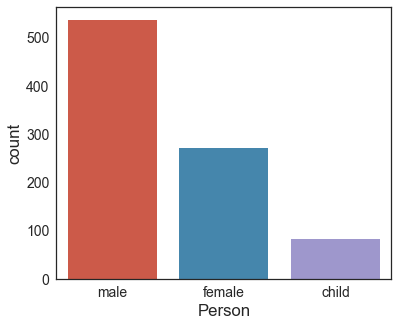

In [9]:
fig, axis = plt.subplots(1,1,figsize=(6,5))
sns.countplot(x='Person', data=titanic, ax=axis)

In [10]:
person_perc = titanic[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
person_perc

,Person,Survived
0,child,0.590361
1,female,0.756458
2,male,0.163873


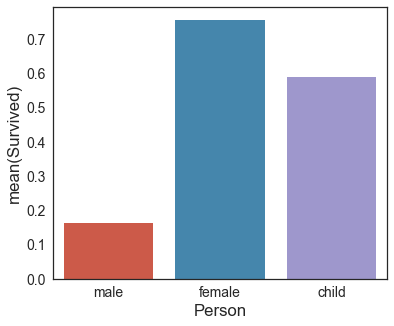

In [11]:
fig, axis = plt.subplots(1,1,figsize=(6,5))
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis, order=['male','female','child'])

### 2.4.2 A heat map of correlation may give us a understanding of which variables are important
*Select the cell below and run it by pressing the play button.*

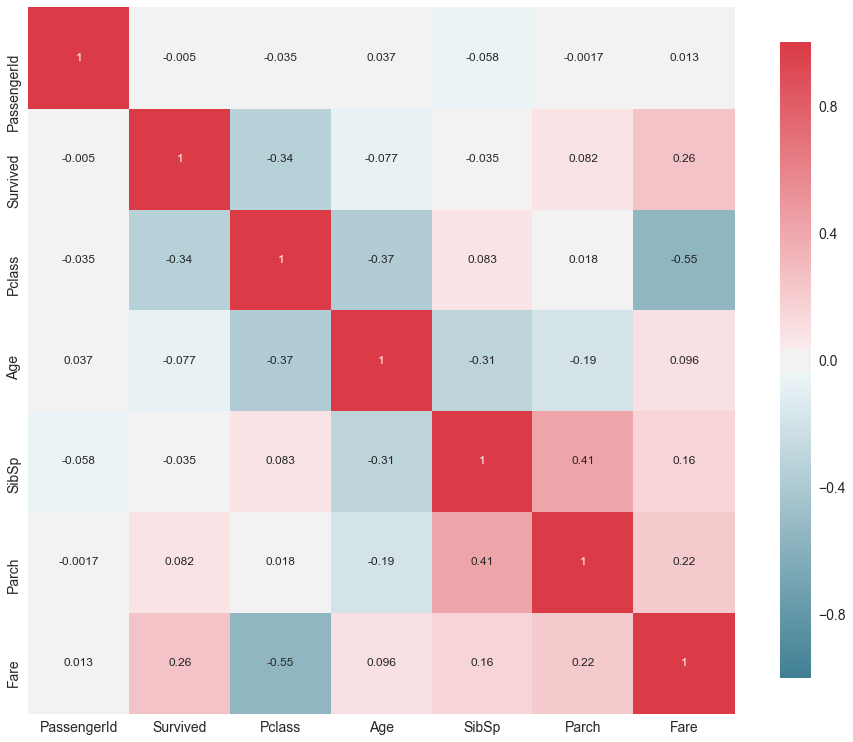

In [12]:
plot_correlation_map( titanic )

### 2.4.3 Let's further explore the relationship between the features and survival of passengers 


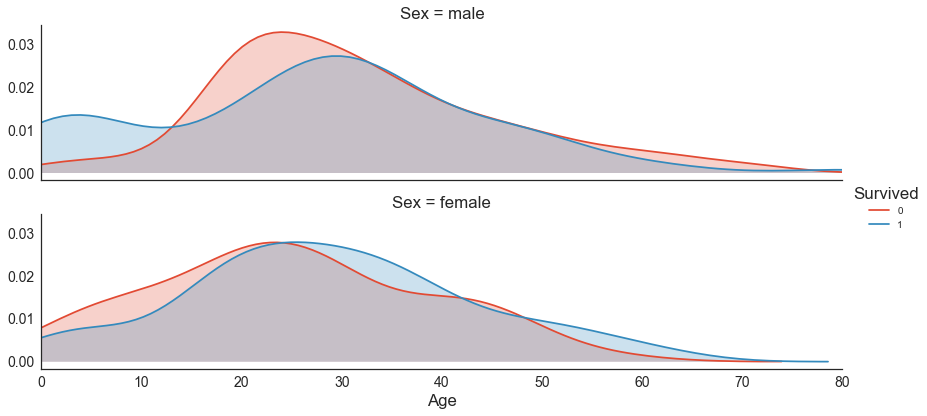

In [13]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

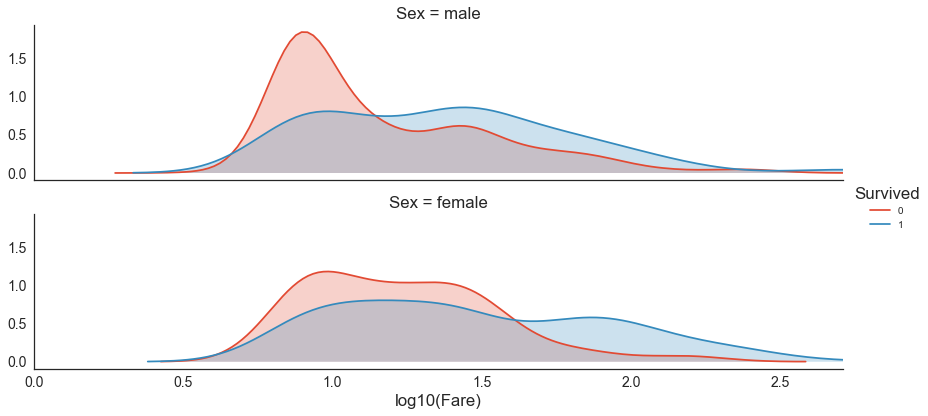

In [14]:
# Plot distributions of Age of passangers who survived or did not survive
titanic['log10(Fare)'] = np.log10(titanic.Fare)
plot_distribution( titanic , var = 'log10(Fare)' , target = 'Survived' , row = 'Sex' )

Consider the graphs above. Differences between survival for different values is what will be used to separate the target variable (survival in this case) in the model. If the two lines had been about the same, then it would not have been a good variable for our predictive model. 

Consider some key questions such as; what age does males/females have a higher or lower probability of survival? 

### 2.4.4 Embarked
We can also look at categorical variables like Embarked and their relationship with survival.

- C = Cherbourg  
- Q = Queenstown
- S = Southampton

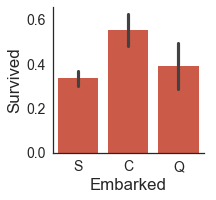

In [15]:
# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

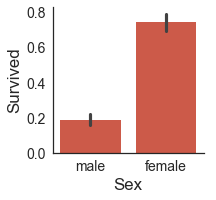

In [16]:
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

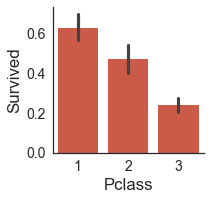

In [17]:
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

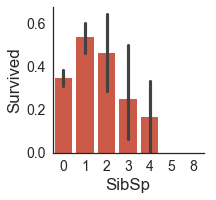

In [18]:
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

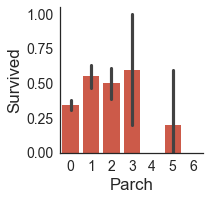

In [19]:
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

# 3. Data Preparation

## 3.1 Categorical variables need to be transformed to numeric variables
The variables *Embarked*, *Pclass* and *Sex* are treated as categorical variables. Some of our model algorithms can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

This variable will have a value 1 if the row has a particular value and a value 0 if not. *Sex* is a dichotomy (old school gender theory) and will be encoded as one binary variable (0 or 1).

*Select the cells below and run it by pressing the play button.*

In [20]:
full = titanic

In [21]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [22]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [23]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


## 3.2 Fill missing values in variables
Most machine learning alghorims require all variables to have values in order to use it for training the model. The simplest method is to fill missing values with the average of the variable across all observations in the training set.

*Select the cells below and run it by pressing the play button.*

In [24]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


## 3.3 Feature Engineering &ndash; Creating new variables
Credit: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

### 3.3.1 Extract titles from passenger names
Titles reflect social status and may predict survival probability

*Select the cell below and run it by pressing the play button.*

In [25]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


### 3.3.2 Extract Cabin category information from the Cabin number

In [26]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3.3.3 Extract family size

In [27]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


### 3.3.3 Extract sex

In [28]:
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

### 3.3.4 Extract Embarked OHE

In [29]:
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


### 3.3.5 Extract Pclass OHE

In [30]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


### 3.4.1 Join extracted features

In [31]:
full_X = pd.concat( [ imputed , embarked , cabin , sex, pclass, family ] , axis=1 )
print(full_X.shape)
full_X.head()

(891, 22)


,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,Cabin_T,Cabin_U,Sex,Pclass_1,Pclass_2,Pclass_3,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1,0.0,0.0,1.0,2,0,1,0
1,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0,1.0,0.0,0.0,2,0,1,0
2,26.0,7.9250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0,0.0,0.0,1.0,1,1,0,0
3,35.0,53.1000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0,1.0,0.0,0.0,2,0,1,0
4,35.0,8.0500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1,0.0,0.0,1.0,1,1,0,0


### 3.4.2 Split into train & validation data

In [32]:
train_X , valid_X , train_y , valid_y = train_test_split( full_X , titanic.Survived , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape )

(891, 22) (623, 22) (268, 22) (623,) (268,)


## 4. Predict survival

### 4.1 Quality assurance function

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

    
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    df = df[labels].set_index(pd.MultiIndex(
        levels=[[u'True'], labels],
        labels=[[0, 0], [0, 1]],
    )).T.set_index(pd.MultiIndex(
        levels=[[u'False'], labels],
        labels=[[0, 0], [0, 1]],
    )).T
    return df


def report_model(model):
    model.fit(train_X, train_y)
    print('Accuracy: {:.2f}%'.format(100. * accuracy_score(valid_y, model.predict(valid_X))))
    return cm2df(confusion_matrix(valid_y, model.predict(valid_X)), ['Died', 'Survived'])

### 4.2 Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
report_model(LogisticRegression())

Accuracy: 80.22%


False         
               Died Survived
True Died       134       24
     Survived    29       81

In [35]:
from sklearn.linear_model import LogisticRegressionCV
report_model(LogisticRegressionCV())

Accuracy: 80.60%


False         
               Died Survived
True Died       134       24
     Survived    28       82

[  3.90372927e-02   4.69685501e-03   1.48957945e-01   2.79431790e-01
   2.26514951e-01   1.46631231e-01   5.83125212e-01   6.00681935e-01
   9.10040966e-01   1.16222467e+00   8.39259233e-04   1.00230580e+00
   3.58757556e-01   5.49598152e-01   2.40020813e+00   5.25096010e-01
   1.94419451e-01   7.21260033e-01   9.28778507e-02   5.34864277e-01
   8.31370826e-01   1.36797967e+00]
0.829855537721


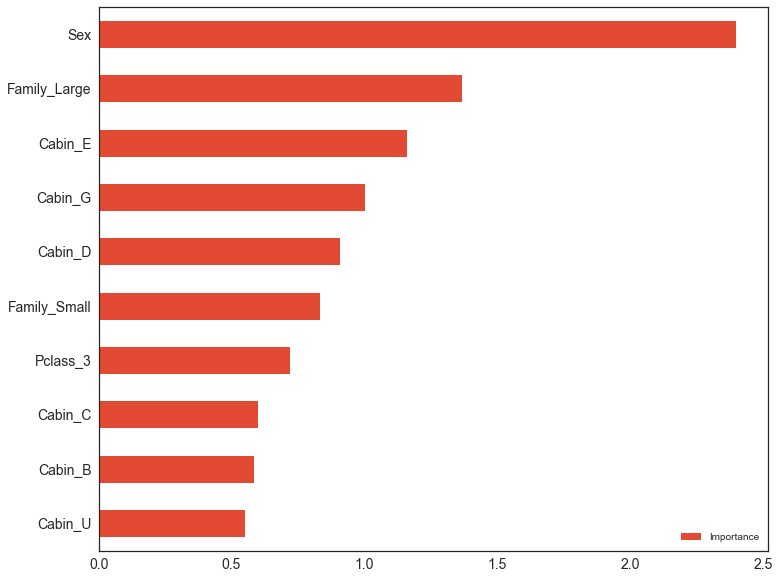

In [36]:
model = LogisticRegressionCV()
model.fit(train_X, train_y)

plot_model_var_imp(model, train_X, train_y)

### 4.2 Decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
report_model(DecisionTreeClassifier())

Accuracy: 75.00%


False         
               Died Survived
True Died       128       30
     Survived    37       73

In [38]:
report_model(DecisionTreeClassifier(max_depth=8))

Accuracy: 81.72%


False         
               Died Survived
True Died       143       15
     Survived    34       76

In [39]:
report_model(DecisionTreeClassifier(max_depth=5))

Accuracy: 77.61%


False         
               Died Survived
True Died       144       14
     Survived    46       64

In [40]:
report_model(DecisionTreeClassifier(max_depth=3))

Accuracy: 83.96%


False         
               Died Survived
True Died       144       14
     Survived    29       81

In [41]:
report_model(DecisionTreeClassifier(max_depth=2))

Accuracy: 76.49%


False         
               Died Survived
True Died       154        4
     Survived    59       51

[ 0.0750084   0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.56853722  0.05344674  0.          0.20316589  0.05977026  0.          0.
  0.04007149]
0.821829855538


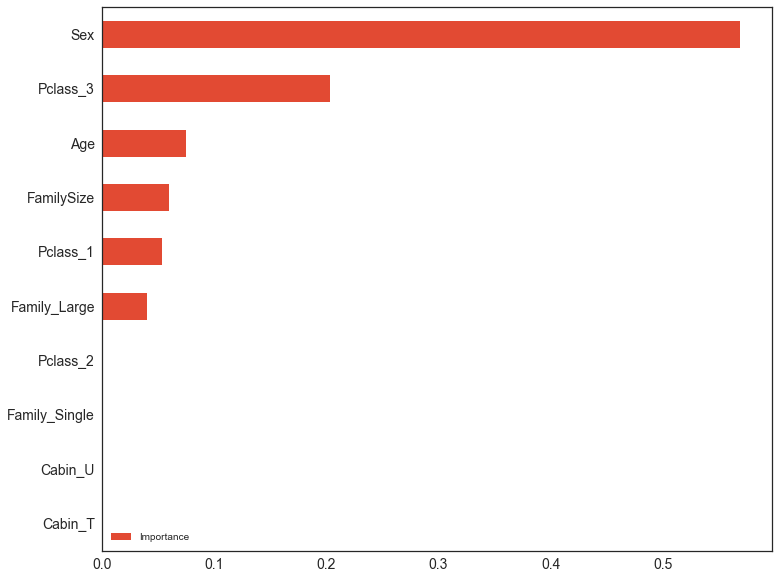

In [43]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(train_X, train_y)

plot_model_var_imp(model, train_X, train_y)

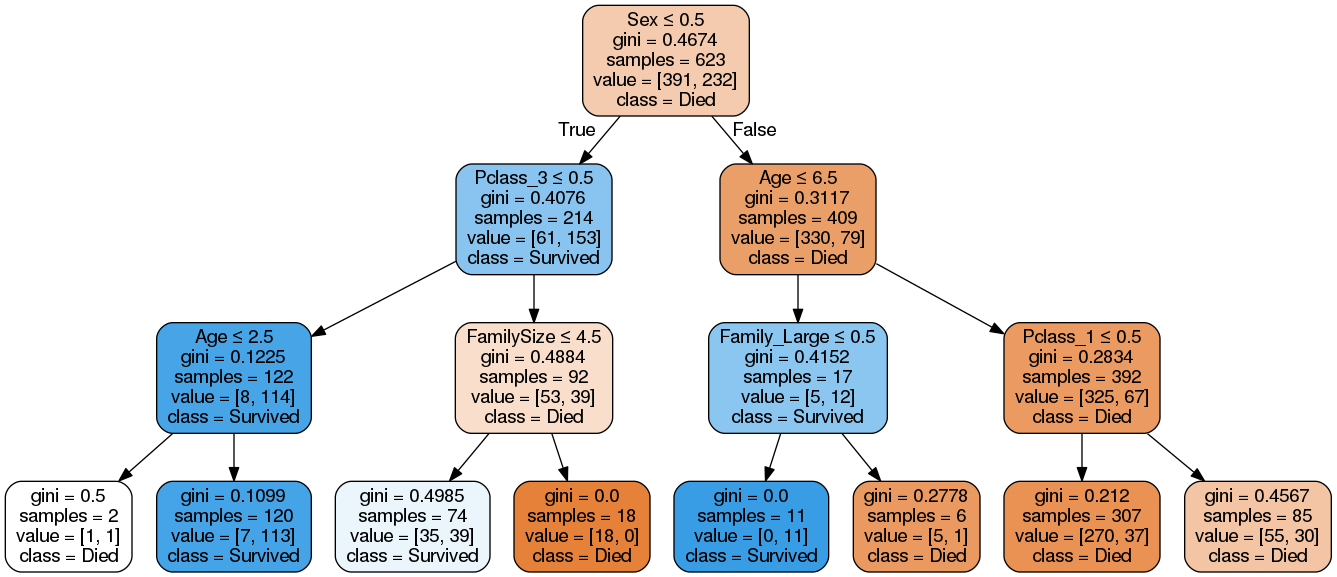

In [44]:
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot

dot_data = StringIO()  
export_graphviz(model, out_file=dot_data,  
                     feature_names=train_X.columns,  
                     class_names=['Died', 'Survived'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png())  